<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import TimeSeriesSplit
from datetime import date, timedelta


RANDOM = 42

In [2]:
try:
    df = pd.read_csv('taxi.csv', parse_dates =[0], index_col= 0)
except:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates =[0], index_col= 0)
    
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.isna().sum()

num_orders    0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
#ресемплирум данные, чтобы интервал между наблюдениями был 1 час
df = df.resample("1H").sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [6]:
#Проверим данные на монотонность
df.index.is_monotonic

True

## Анализ

In [7]:
#Создадим новые признаки для анализа
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [8]:
make_features(df, 24, 20)
df

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,169.35
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,163.85
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,157.75


<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

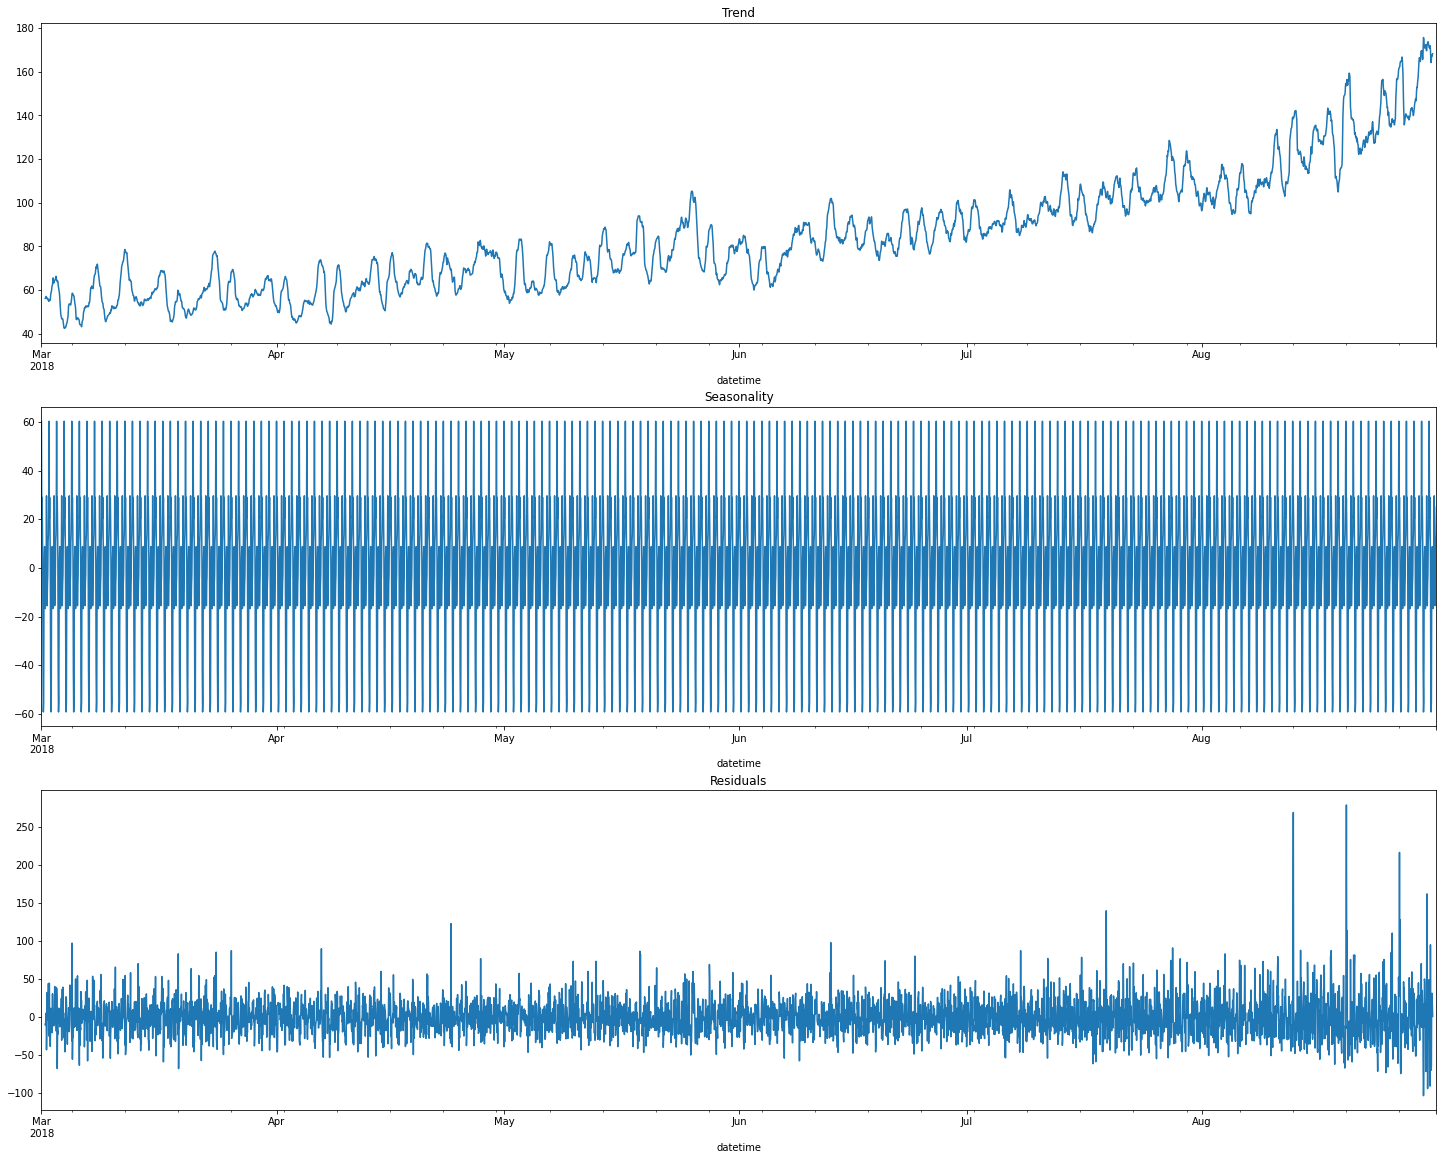

In [9]:
#построим график тренда, сезонноити и остатка
decomposed = seasonal_decompose(df["num_orders"])
fig, ax = plt.subplots(3,1,figsize = (25,20))

decomposed.trend.plot(ax=ax[0],title = 'Trend')
decomposed.seasonal.plot(ax=ax[1],title = 'Seasonality')
decomposed.resid.plot(ax=ax[2],title = 'Residuals')

Мало что можно сказать о данных по такому графику)) попробуем построить эти же графики по нескольким неделям, где нет праздников. Остатки уберем, тк не понимаю какую пользу они в себе несут. 
Построим графики по трем случайным неделям

<AxesSubplot:title={'center':'Май, Seasonality'}, xlabel='datetime'>

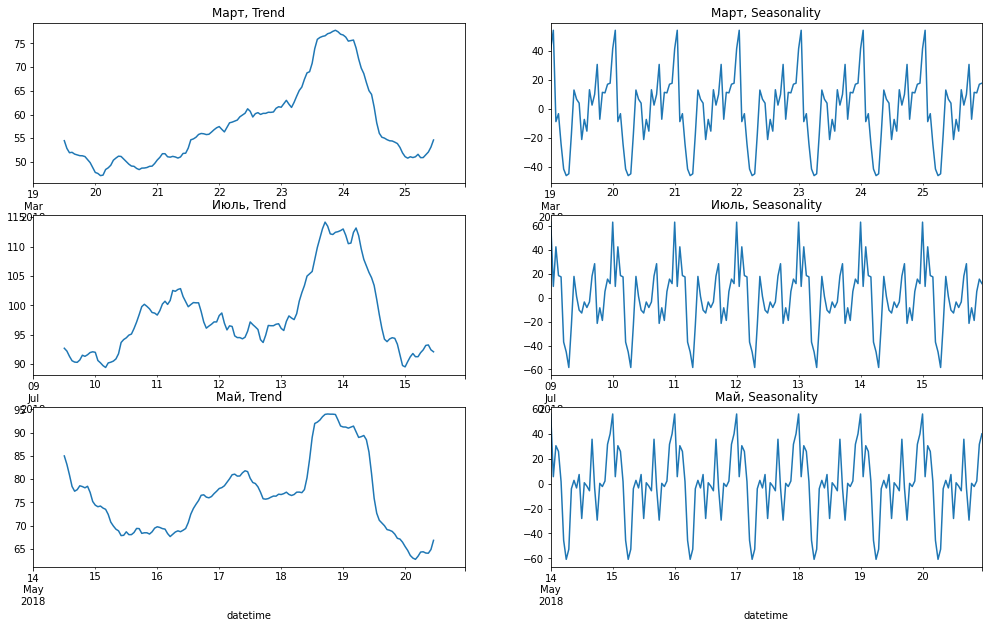

In [10]:
#построим график тренда, сезонноити и остатка
#зима
fig, axs = plt.subplots(3,2, figsize = (17,10))

seasonal_decompose(df['2018-03-19':'2018-03-25']["num_orders"]).trend.plot(ax=axs[0, 0],title = 'Март, Trend')
seasonal_decompose(df['2018-03-19':'2018-03-25']["num_orders"]).seasonal.plot(ax=axs[0, 1],title = 'Март, Seasonality')

seasonal_decompose(df['2018-07-09':'2018-07-15']["num_orders"]).trend.plot(ax=axs[1, 0],title = 'Июль, Trend')
seasonal_decompose(df['2018-07-09':'2018-07-15']["num_orders"]).seasonal.plot(ax=axs[1, 1],title = 'Июль, Seasonality')

seasonal_decompose(df['2018-05-14':'2018-05-20']["num_orders"]).trend.plot(ax=axs[2, 0],title = 'Май, Trend')
seasonal_decompose(df['2018-05-14':'2018-05-20']["num_orders"]).seasonal.plot(ax=axs[2, 1],title = 'Май, Seasonality')

### Вывод
На графиках можно заметить, что количество заказов как правило возрастает к середине недели. Пик количества заказов прхиодится на пятницу. Сезонность не меняется - ночью провал, к утру - заметное увеличение и к вечеру пиковое количество заказов, которое снижается к ночи.

## Обучение

In [11]:
#Разделим данные на обучающую и тренировочные выборки
df = df.dropna()
features_train, features_test, target_train, target_test = train_test_split(df.drop("num_orders",axis = 1),
                                                                            df['num_orders'],
                                                                            test_size=0.1,
                                                                            shuffle = False,
                                                                            random_state=RANDOM)


In [12]:
#Подберем лучшие гиперпараметра модели градиентного бустинга
splits = TimeSeriesSplit(n_splits=3)

catboost = CatBoostRegressor(loss_function='RMSE',random_state = RANDOM)
param_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(param_cat,
            Pool(features_train,target_train), cv=splits, verbose=True)

0:	learn: 72.4507819	test: 107.5710808	best: 107.5710808 (0)	total: 51ms	remaining: 50.9s
1:	learn: 66.2699768	test: 100.0130136	best: 100.0130136 (1)	total: 54.8ms	remaining: 27.3s
2:	learn: 61.0182613	test: 94.2547152	best: 94.2547152 (2)	total: 58.2ms	remaining: 19.3s
3:	learn: 56.6135709	test: 89.4174800	best: 89.4174800 (3)	total: 61.6ms	remaining: 15.3s
4:	learn: 52.3816565	test: 84.2803270	best: 84.2803270 (4)	total: 64.9ms	remaining: 12.9s
5:	learn: 48.4843366	test: 79.4968334	best: 79.4968334 (5)	total: 68.2ms	remaining: 11.3s
6:	learn: 44.9837090	test: 75.2370400	best: 75.2370400 (6)	total: 71.8ms	remaining: 10.2s
7:	learn: 41.8829097	test: 71.1840839	best: 71.1840839 (7)	total: 75.6ms	remaining: 9.38s
8:	learn: 39.3422444	test: 68.0336305	best: 68.0336305 (8)	total: 78.8ms	remaining: 8.68s
9:	learn: 37.0235266	test: 64.8812740	best: 64.8812740 (9)	total: 82.1ms	remaining: 8.12s
10:	learn: 34.9928648	test: 62.0323416	best: 62.0323416 (10)	total: 85.6ms	remaining: 7.69s
11:	le

In [13]:
#Подберем лучшие гиперпараметра модели случайного леса
RF = RandomForestRegressor(random_state=RANDOM)
parametrs = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF, parametrs, cv = splits, n_jobs=-1, verbose=True)
RF_grid.fit(features_train,target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             verbose=True)

In [14]:
#обучим модель случайного леса с лучшими гиперпараметрами
rf = RandomForestRegressor(max_depth= RF_grid.best_params_['max_depth'], 
                           n_estimators= RF_grid.best_params_['n_estimators'], 
                           random_state=RANDOM)

rf.fit(features_train,target_train)

RandomForestRegressor(max_depth=10, n_estimators=150, random_state=42)

In [15]:
#Оценим качество модели случайного леса
scores_rf = cross_val_score(rf, features_train, target_train, scoring='neg_mean_squared_error', cv=splits)
scores_rf = (abs(scores_rf.mean()))**0.5
print(f'RMSE модели случайного леса - {scores_rf}.')

RMSE модели случайного леса - 28.05943925145028.


In [16]:
#обучим модель с лучшими гиперпараметрами
meow = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
meow.fit(Pool(features_train,target_train))

0:	learn: 33.8941180	total: 3.76ms	remaining: 3.76s
100:	learn: 16.5907351	total: 375ms	remaining: 3.34s
200:	learn: 12.6456810	total: 749ms	remaining: 2.98s
300:	learn: 10.0914427	total: 1.1s	remaining: 2.56s
400:	learn: 8.1712414	total: 1.47s	remaining: 2.19s
500:	learn: 6.7506974	total: 1.87s	remaining: 1.86s
600:	learn: 5.5408612	total: 2.28s	remaining: 1.51s
700:	learn: 4.5532233	total: 2.63s	remaining: 1.12s
800:	learn: 3.7253136	total: 2.98s	remaining: 740ms
900:	learn: 3.0958621	total: 3.33s	remaining: 366ms
999:	learn: 2.5927656	total: 3.71s	remaining: 0us


In [17]:
params = {
    'loss_function': 'RMSE',
    'depth': catboost_grid["params"]['depth'],
    'learning_rate': catboost_grid["params"]['learning_rate']
}

scores = cv(Pool(features_train, target_train),
            params,
            fold_count=5)

best_score = scores['test-RMSE-mean'].min()

Training on fold [0/5]
0:	learn: 65.6747861	test: 66.4792732	best: 66.4792732 (0)	total: 3.9ms	remaining: 3.9s
1:	learn: 51.0380058	test: 52.3453168	best: 52.3453168 (1)	total: 7.47ms	remaining: 3.73s
2:	learn: 41.2845249	test: 42.5675378	best: 42.5675378 (2)	total: 11.1ms	remaining: 3.69s
3:	learn: 35.1231595	test: 36.3808831	best: 36.3808831 (3)	total: 14.4ms	remaining: 3.58s
4:	learn: 31.1247485	test: 32.3490116	best: 32.3490116 (4)	total: 17.8ms	remaining: 3.54s
5:	learn: 28.6431640	test: 30.0652602	best: 30.0652602 (5)	total: 21.1ms	remaining: 3.49s
6:	learn: 27.1606098	test: 28.6225029	best: 28.6225029 (6)	total: 24.4ms	remaining: 3.46s
7:	learn: 26.0856011	test: 27.5779233	best: 27.5779233 (7)	total: 27.7ms	remaining: 3.43s
8:	learn: 25.2218999	test: 26.8174719	best: 26.8174719 (8)	total: 31ms	remaining: 3.42s
9:	learn: 24.6957975	test: 26.4306064	best: 26.4306064 (9)	total: 34.5ms	remaining: 3.42s
10:	learn: 24.4153875	test: 26.1201262	best: 26.1201262 (10)	total: 37.8ms	remain

In [18]:
print(f'RMSE модели catboost - {best_score}.')

RMSE модели catboost - 23.676192185411463.


### Вывод
Модель catboost удовлетворяет условиям задачи на обучающей выборке.

## Тестирование

In [19]:
#Проверим ошибку лучшей модели на тестовой выборке
print("RMSE модели catboost на тестовой выборке:",(mean_squared_error(target_test,meow.predict(features_test),squared=False)))

RMSE модели catboost на тестовой выборке: 42.84780773661236


<AxesSubplot:xlabel='datetime'>

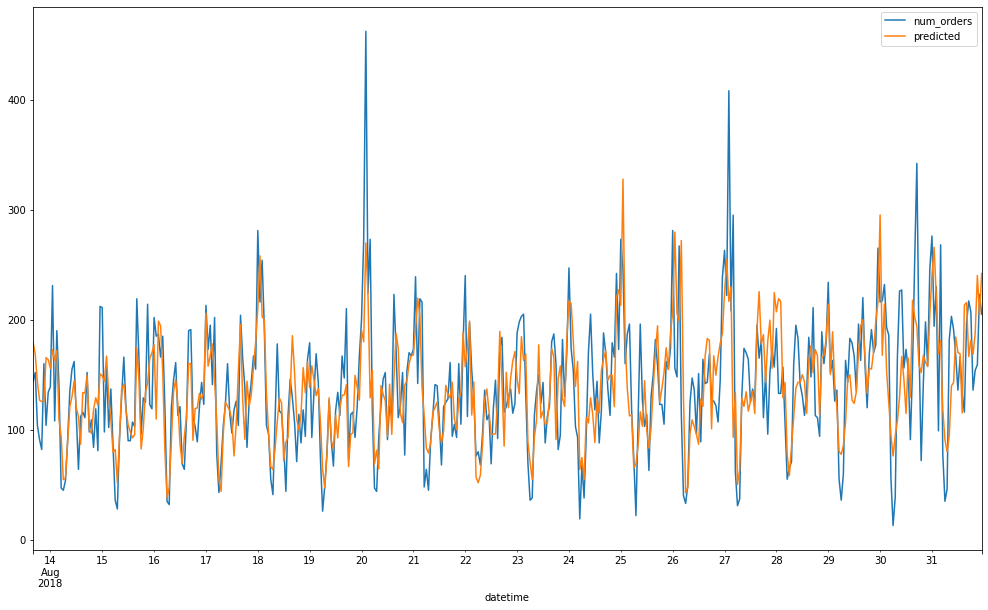

In [83]:
predicted = pd.DataFrame(meow.predict(features_test), index = target_test.index, columns = ['predicted'])
pred_test = pd.merge(target_test, predicted, how = 'outer', left_index=True, right_index=True)
pred_test.plot(figsize = (17,10))

## Выводы
Изучена сезонность и тренд изменения поступающих заказов в течение недели.Обучены модель случайного леса и градиентного бустинга. Подобраны лучшие гиперпараматры. RMSE на тестовой выбоке удовлетворяет условиям.